--- Analyzing Raw Voxel Histograms by View for Patient: 16406M ---


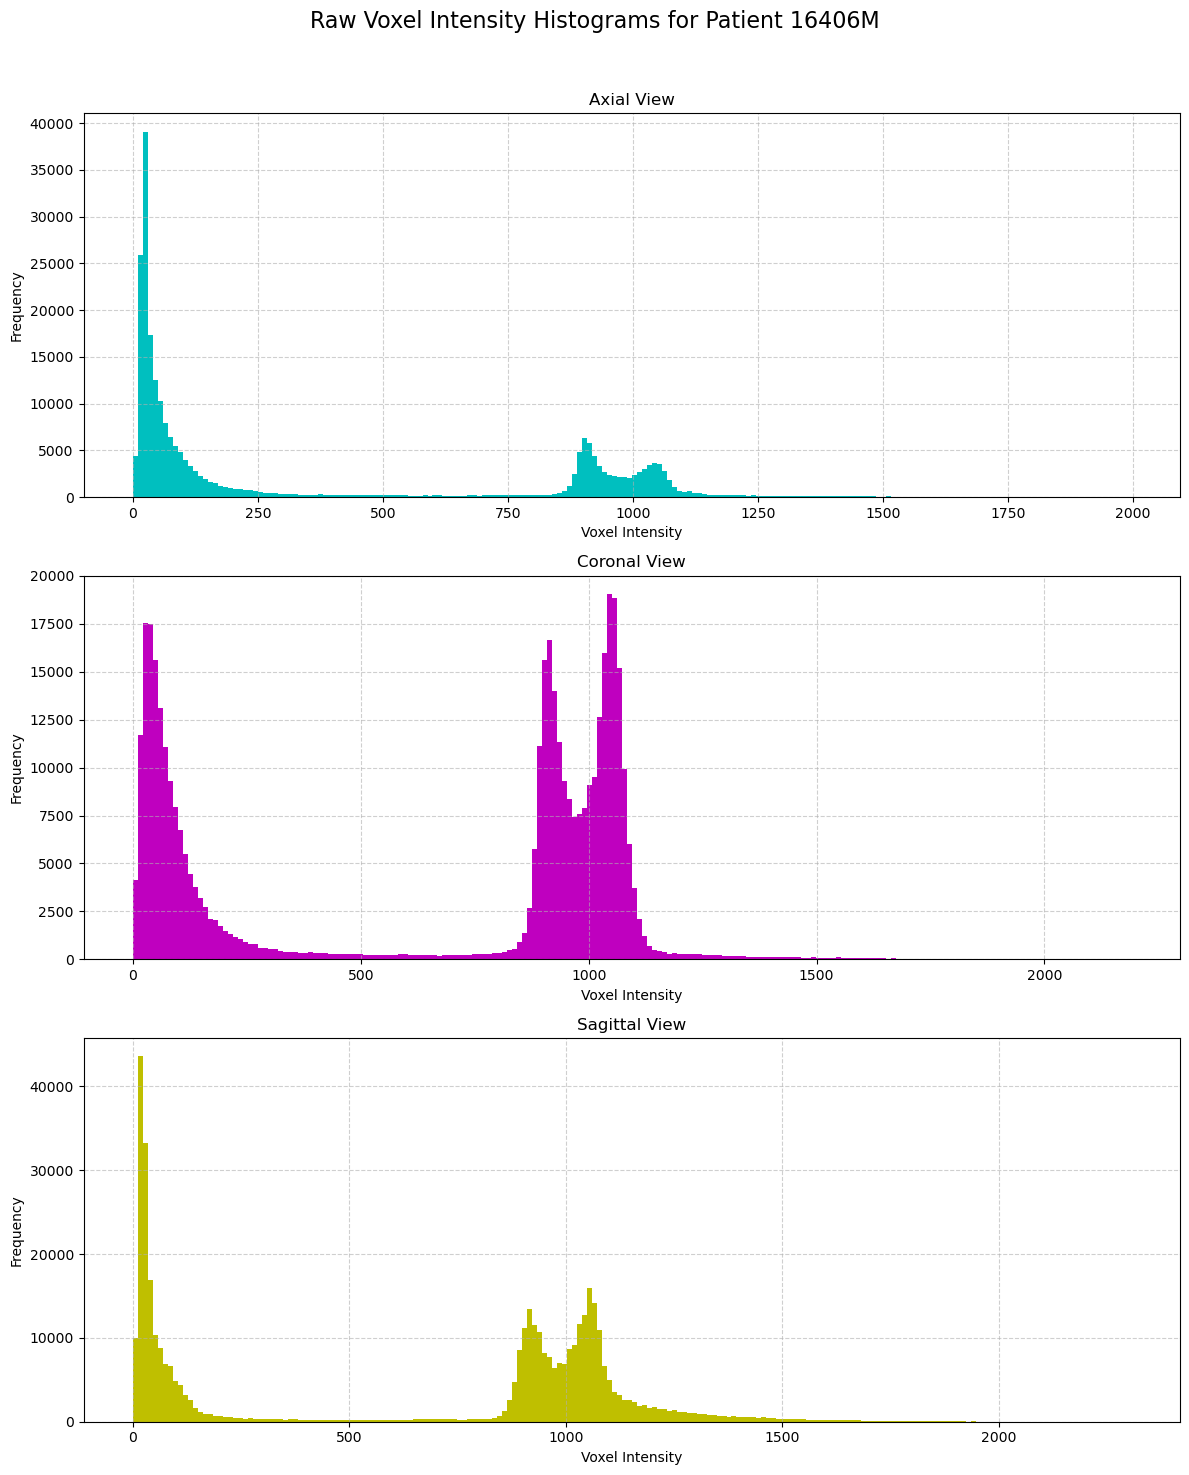

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
RAW_DATA_ROOT = Path("/mnt/hot/public/COPDGene-1")
test_patient_id = '16406M'

# --- Load and Process Data ---
print(f"--- Analyzing Raw Voxel Histograms by View for Patient: {test_patient_id} ---")
try:
    nii_path = RAW_DATA_ROOT / f"{test_patient_id}_INSP_image.nii.gz"
    nii_img = nib.load(nii_path)
    raw_scan_3d = nii_img.get_fdata().astype(np.float32)

    # --- Get center slice indices ---
    center_x, center_y, center_z = [dim // 2 for dim in raw_scan_3d.shape]
    
    # --- Extract data for each view (only pixels > 0) ---
    axial_slice_data = raw_scan_3d[:, :, center_z].flatten()
    coronal_slice_data = raw_scan_3d[:, center_y, :].flatten()
    sagittal_slice_data = raw_scan_3d[center_x, :, :].flatten()

    axial_body = axial_slice_data[axial_slice_data > 0]
    coronal_body = coronal_slice_data[coronal_slice_data > 0]
    sagittal_body = sagittal_slice_data[sagittal_slice_data > 0]
    
    # --- Create and Plot the Histograms ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(f'Raw Voxel Intensity Histograms for Patient {test_patient_id}', fontsize=16)

    axes[0].hist(axial_body, bins=200, color='c', label='Axial')
    axes[0].set_title("Axial View")
    axes[0].set_xlabel("Voxel Intensity")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].hist(coronal_body, bins=200, color='m', label='Coronal')
    axes[1].set_title("Coronal View")
    axes[1].set_xlabel("Voxel Intensity")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    axes[2].hist(sagittal_body, bins=200, color='y', label='Sagittal')
    axes[2].set_title("Sagittal View")
    axes[2].set_xlabel("Voxel Intensity")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [6]:
import nibabel as nib
from pathlib import Path

# --- Configuration ---
RAW_DATA_ROOT = Path("/mnt/hot/public/COPDGene-1")
test_patient_id = '16406M'

# --- Load the NIfTI file and check its header ---
print(f"--- Checking Header Metadata for Patient: {test_patient_id} ---")
try:
    nii_path = RAW_DATA_ROOT / f"{test_patient_id}_INSP_image.nii.gz"
    nii_img = nib.load(nii_path)

    # Attempt to access the scaling factors from the header
    print(nii_img.header)

except Exception as e:
    print(f"An error occurred: {e}")

--- Checking Header Metadata for Patient: 16406M ---
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 512 512 816   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.76171875 0.76171875 0.45       0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
q

In [5]:
import SimpleITK as sitk
img_path = "/mnt/hot/public/COPDGene-1/16244M_INSP_image.nii.gz"
mask_path = "/mnt/hot/public/COPDGene-1/16244M_INSP_mask.nii.gz"

img_itk = sitk.ReadImage(img_path)
mask_itk = sitk.ReadImage(mask_path)

# These MUST be identical
print("Origin identical:", img_itk.GetOrigin() == mask_itk.GetOrigin())
print("Spacing identical:", img_itk.GetSpacing() == mask_itk.GetSpacing())
print("Direction identical:", img_itk.GetDirection() == mask_itk.GetDirection())

Origin identical: True
Spacing identical: True
Direction identical: True


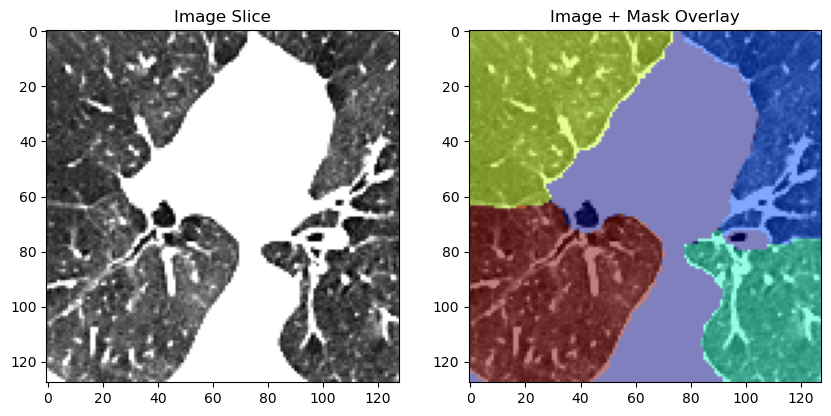

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img = np.load("/mnt/hot/public/Akul/exhale_pred_data_10pct/inhale/10708Y.npy")
mask = np.load("/mnt/hot/public/Akul/exhale_pred_data_10pct/masks/inhale/10708Y_INSP_mask.npy")

sl = 64 # Central slice
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[sl, :, :], cmap='gray')
plt.title("Image Slice")

plt.subplot(1, 2, 2)
plt.imshow(img[sl, :, :], cmap='gray')
plt.imshow(mask[sl, :, :], cmap='jet', alpha=0.5) # Overlay mask
plt.title("Image + Mask Overlay")
plt.show()

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- Paste the SpatialTransformer class from models.py here ---
from models import SpatialTransformer

# --- Test Logic ---
IMG_SIZE = (64, 64, 64) # Use smaller size for easier testing
CUBE_SIZE = 10
SHIFT_VAL = 20 # How many pixels to shift

# 1. Instantiate the transformer
st = SpatialTransformer(size=IMG_SIZE)

# 2. Create a test image with a cube in the center
img = torch.zeros(1, 1, *IMG_SIZE)
c_start = (IMG_SIZE[0] // 2) - (CUBE_SIZE // 2)
c_end = (IMG_SIZE[0] // 2) + (CUBE_SIZE // 2)
img[:, :, c_start:c_end, c_start:c_end, c_start:c_end] = 1.0

# 3. Create a test DVF to shift 20 pixels in the Z-axis (Channel 0)
# DVF shape is (B, 3, D, H, W). Channel 0=Z, 1=Y, 2=X
dvf = torch.zeros(1, 3, *IMG_SIZE)
dvf[:, 0, ...] = SHIFT_VAL # Shift Z-axis (dim 0)

# 4. Apply the transform
warped_img = st(img.float(), dvf.float())

# 5. Check the results
original_slice_idx = IMG_SIZE[0] // 2
shifted_slice_idx = original_slice_idx + SHIFT_VAL

original_slice_sum = img[0, 0, original_slice_idx, :, :].sum()
warped_original_slice_sum = warped_img[0, 0, original_slice_idx, :, :].sum()
warped_shifted_slice_sum = warped_img[0, 0, shifted_slice_idx, :, :].sum()

print(f"--- Testing Z-Axis (Channel 0) Shift ---")
print(f"Original cube center slice: {original_slice_idx} (Sum: {original_slice_sum.item()})")
print(f"Sum at original slice {original_slice_idx} in warped image: {warped_original_slice_sum.item():.2f}")
print(f"Sum at *shifted* slice {shifted_slice_idx} in warped image: {warped_shifted_slice_sum.item():.2f}")

if warped_shifted_slice_sum > 80: # 10x10 cube = 100, allow for interpolation
    print("\nSUCCESS: Cube correctly shifted in the Z-axis (slice dimension).")
else:
    print("\nFAILURE: Cube did NOT shift in the Z-axis.")
    
# You can repeat this test for Y (dvf[:, 1, ...]) and X (dvf[:, 2, ...])
# To test Y: check a row sum, e.g., warped_img[0, 0, original_slice_idx, shifted_slice_idx, :].sum()
# To test X: check a col sum, e.g., warped_img[0, 0, original_slice_idx, :, shifted_slice_idx].sum()

--- Testing Z-Axis (Channel 0) Shift ---
Original cube center slice: 32 (Sum: 100.0)
Sum at original slice 32 in warped image: 0.00
Sum at *shifted* slice 52 in warped image: 0.00

FAILURE: Cube did NOT shift in the Z-axis.


In [14]:
import SimpleITK as sitk
import numpy as np
from pathlib import Path
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Configuration ---
# Set this to your raw data directory
RAW_DATA_ROOT = Path("/mnt/hot/public/COPDGene-1") 
# This is your fixed target shape from the model
TARGET_SHAPE = np.array([128, 128, 128]) 
# How many files to check? (for a quick test)
# Set to -1 to check all files.
FILES_TO_CHECK = -1
# --- End Configuration ---

def find_max_physical_dimensions():
    """
    Iterates through the dataset to find the largest physical
    dimensions (in mm) of any scan.
    """
    # Use glob to find the mask files. 
    # Using inhale masks, but exhale would also work.
    search_pattern = str(RAW_DATA_ROOT / "*_INSP_mask.nii.gz")
    all_mask_files = glob.glob(search_pattern)
    
    if not all_mask_files:
        print(f"Error: No mask files found at {search_pattern}")
        return None, None

    if FILES_TO_CHECK > 0:
        all_mask_files = all_mask_files[:FILES_TO_CHECK]
        print(f"--- Analyzing a subset of {len(all_mask_files)} files ---")
    else:
        print(f"--- Analyzing all {len(all_mask_files)} files ---")

    max_physical_dims = np.array([0.0, 0.0, 0.0])
    max_dim_file = ""

    for f_path in tqdm(all_mask_files, desc="Analyzing scans"):
        try:
            itk_image = sitk.ReadImage(f_path)
            
            # Get size in pixels (e.g., [512, 512, 480])
            original_size_px = np.array(itk_image.GetSize())
            
            # Get spacing in mm (e.g., [0.65, 0.65, 0.7])
            original_spacing_mm = np.array(itk_image.GetSpacing())
            
            # Get physical size in mm (e.g., [332.8, 332.8, 336.0])
            # Note: ITK size is (x, y, z), matching spacing.
            physical_size_mm = original_size_px * original_spacing_mm
            
            # Check if this image is larger in any dimension
            if np.any(physical_size_mm > max_physical_dims):
                # Update max dims component-wise
                max_physical_dims = np.maximum(max_physical_dims, physical_size_mm)
                max_dim_file = f_path

        except Exception as e:
            print(f"Warning: Could not read {f_path}. Error: {e}")
            
    # SimpleITK size/spacing is (X, Y, Z)
    print("\n--- Analysis Complete ---")
    print(f"Max physical dimensions (X, Y, Z) found: {max_physical_dims} mm")
    print(f"Largest scan found: {max_dim_file}")
    
    return max_physical_dims, max_dim_file

def calculate_and_visualize(max_physical_dims, sample_file_path):
    """
    Calculates the new spacing and visualizes the result.
    """
    if max_physical_dims is None or not sample_file_path:
        print("Analysis failed, cannot visualize.")
        return

    # 1. Calculate Optimal Spacing
    # required_spacing = max_physical_size / target_pixel_size
    required_spacing_per_dim = max_physical_dims / TARGET_SHAPE
    
    print(f"\nRequired spacing (X, Y, Z): {required_spacing_per_dim} mm/px")
    
    # To maintain isotropicity and ensure it fits, we must use
    # the largest of the three required spacings.
    optimal_spacing_val = np.max(required_spacing_per_dim)
    
    # Add a small buffer (e.g., 5%) to be safe
    optimal_spacing_val *= 1.05
    
    NEW_TARGET_SPACING = (float(optimal_spacing_val), float(optimal_spacing_val), float(optimal_spacing_val))
    
    print("-----------------------------------------------------------------")
    print(f"RECOMMENDED new TARGET_SPACING: {NEW_TARGET_SPACING}")
    print("Update `preprocess_data.py` and `preprocess_masks.py` with this value.")
    print("-----------------------------------------------------------------")

    # 2. Visualize the result
    print(f"\n--- Visualizing result with '{Path(sample_file_path).name}' ---")
    
    # We need the IMAGE, not the mask, for visualization
    sample_img_path = sample_file_path.replace("_mask.nii.gz", "_image.nii.gz")
    if not Path(sample_img_path).exists():
        print(f"Could not find matching image: {sample_img_path}")
        # Fallback to mask if image not found
        sample_img_path = sample_file_path 
        
    itk_image = sitk.ReadImage(sample_img_path)

    # 3. Resample and Pad (using the logic from your script)
    resampled_data = resample_and_pad_image(itk_image, NEW_TARGET_SPACING, TARGET_SHAPE)
    
    # 4. Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # SimpleITK GetArrayFromImage is (D, H, W) or (Z, Y, X)
    # Our TARGET_SHAPE is (X, Y, Z) from ITK, so array is (Z, Y, X)
    # i.e., (128, 128, 128)
    
    slice_z = resampled_data.shape[0] // 2
    slice_y = resampled_data.shape[1] // 2
    slice_x = resampled_data.shape[2] // 2
    
    axes[0].imshow(resampled_data[slice_z, :, :], cmap='gray')
    axes[0].set_title(f"Axial View (Z-slice {slice_z})")
    axes[0].axhline(slice_y, color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(slice_x, color='g', linestyle='--', alpha=0.5)
    
    axes[1].imshow(resampled_data[:, slice_y, :], cmap='gray')
    axes[1].set_title(f"Coronal View (Y-slice {slice_y})")
    axes[1].axhline(slice_z, color='r', linestyle='--', alpha=0.5)
    axes[1].axvline(slice_x, color='g', linestyle='--', alpha=0.5)
    
    axes[2].imshow(resampled_data[:, :, slice_x], cmap='gray')
    axes[2].set_title(f"Sagittal View (X-slice {slice_x})")
    axes[2].axhline(slice_z, color='r', linestyle='--', alpha=0.5)
    axes[2].axvline(slice_y, color='g', linestyle='--', alpha=0.5)
    
    plt.suptitle("Center Slices After Resampling with *New* Spacing")
    plt.tight_layout()
    plt.show()

def resample_and_pad_image(itk_image, target_spacing, target_shape_px):
    """
    A copy of the resampling logic from your preprocessing scripts
    for visualization.
    """
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize() # (X, Y, Z)

    # Calculate new size in pixels based on target spacing
    # Note: target_shape_px is (X, Y, Z)
    new_size_px = [
        int(round(osz * ospc / tspc))
        for osz, ospc, tspc in zip(original_size, original_spacing, target_spacing)
    ]
    
    # Use sitk.sitkLinear for image visualization
    interpolator = sitk.sitkLinear 
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(target_spacing)
    resampler.SetSize(new_size_px)
    resampler.SetOutputDirection(itk_image.GetDirection())
    resampler.SetOutputOrigin(itk_image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(float(np.min(sitk.GetArrayViewFromImage(itk_image))))
    resampler.SetInterpolator(interpolator)

    resampled_image = resampler.Execute(itk_image)
    
    # GetArrayFromImage returns (D, H, W) -> (Z, Y, X)
    resampled_data = sitk.GetArrayFromImage(resampled_image)
    
    # --- Pad or Crop to target shape ---
    # target_shape_px is (X, Y, Z), but resampled_data is (Z, Y, X)
    # We must match the data shape
    current_shape_zyx = resampled_data.shape 
    target_shape_zyx = (target_shape_px[2], target_shape_px[1], target_shape_px[0])

    pad_needed = [(max(0, ts - cs)) for ts, cs in zip(target_shape_zyx, current_shape_zyx)]

    pad_before = [p // 2 for p in pad_needed]
    pad_after = [p - pb for p, pb in zip(pad_needed, pad_before)]

    pad_value = np.min(resampled_data)
    padded_data = np.pad(
        resampled_data,
        list(zip(pad_before, pad_after)),
        mode='constant',
        constant_values=pad_value,
    )

    # Crop if the padded data is larger (shouldn't be, with buffer)
    crop_start = [(ps - ts) // 2 for ps, ts in zip(padded_data.shape, target_shape_zyx)]
    
    cropped_data = padded_data[
        crop_start[0] : crop_start[0] + target_shape_zyx[0],
        crop_start[1] : crop_start[1] + target_shape_zyx[1],
        crop_start[2] : crop_start[2] + target_shape_zyx[2],
    ]
    
    return cropped_data

if __name__ == "__main__":
    max_dims, max_file = find_max_physical_dimensions()
    calculate_and_visualize(max_dims, max_file)

--- Analyzing all 8702 files ---


Analyzing scans:   0%|          | 1/8702 [00:00<26:22,  5.50it/s]

Analyzing scans:   1%|▏         | 125/8702 [00:20<23:19,  6.13it/s]


KeyboardInterrupt: 